<table>
<tr><td><img style="height: 150px;" src="images/geo_hydro1.jpg"></td>
<td bgcolor="#FFFFFF">
    <p style="font-size: xx-large; font-weight: 900; line-height: 100%">AG Dynamics of the Earth</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Jupyter notebooks</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Georg Kaufmann</p>
    </td>
</tr>
</table>

# Angewandte Geophysik II: Kap 6: Magnetik
# IGRF reference model from spherical harmonics
----
*Georg Kaufmann,
Geophysics Section,
Institute of Geological Sciences,
Freie Universität Berlin,
Germany*

We first import libraries we will need. This time, besides the standard `numpy` and `matplotlib`
libraries, we need special functions from the `scipy` package.

In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import sph_harm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker

**CORRECTED TIL HERE**

----
## Read Gauss coefficients for magnetic field IGRF13

We want to reconstruct the IGRF model $IGRF(\theta,\phi)$ from 
Gauss coefficients $C_{nm}$, using the spherical harmonics $Y_{nm}(\theta,\phi)$:
$$
V(r,\theta,\phi) = a \sum\limits_{n=0}^{n_{max}} 
\left( \frac{a}{r} \right)^{n+1}
\sum\limits_{m=0}^{n} C_{nm} Y_{nm}(\theta,\phi)
$$

Here, $V$ [Vs/m] is the geomagnetic potential,
$a= 6371.2$ [km] the mean radius of the Earth,
and $r$ [m], $\theta$ [$^{\circ}$], and $\phi$ [$^{\circ}$] the coordinates.

The Gauss coefficients $C_{nm}$ we read from the file `IGRF13.nm` in the data directory, 
which contains the **coefficients** for the spherical harmonic reconstruction of the IGRF13 
model [**IGRF13**](https://www.ngdc.noaa.gov/IAGA/vmod/igrf.html)
from:

Alken, P., Thébault, E., Beggan, C.D. et al. International Geomagnetic Reference Field: the thirteenth generation. Earth Planets Space 73, 49 (2021). https://doi.org/10.1186/s40623-020-01288-x

Note that the coefficients are given in [nT].

In [2]:
ls data; head data/IGRF13.nm

EIGEN2.nm         IGRF13.nm         TOPO.nm           igrf13coeffs.txt
1 0 -29404.8 0.0
1 1 -1450.9 4652.5
2 0 -2499.6 0.0
2 1 2982.0 -2991.6
2 2 1677.0 -734.6
3 0 1363.2 0.0
3 1 -2381.2 -82.1
3 2 1236.2 241.9
3 3 525.7 -543.4
4 0 903.0 0.0


Note that the Gauss coefficients $C_{nm}$ have a **cosine** and a **sine** term!

- We use the `loadtxt` module from the `numpy` package, skip the first line, because it is a header line.

- We then sort the entries into a 3D array `Cnm` (our $C_{nm}$) for the different degree $n$ and order $m$ values.

- Note that we initially fill the array with `nan`, meaning **not a number**, to mark the positions
with $m>n$ as positions without data.

In [3]:
# open IGRF13 model data file and read data
name1='IGRF13'
infile1='data/IGRF13.nm'
data = np.loadtxt(fname=infile1,skiprows=0)
print(data.shape)
# sort Gauss coefficients into array stokes
nmax = 13
mmax = nmax
Cnm = np.zeros((nmax+1)*(mmax+1)*2).reshape((nmax+1),(mmax+1),2)
Cnm = Cnm*np.nan
for i in range(data.shape[0]):
    n = int(data[i,0])
    m = int(data[i,1])
    Cnm[n,m,0] = data[i,2]
    Cnm[n,m,1] = data[i,3]
    
# check a few Gauss coefficients
n=0;m=0; print('n=',n,' m=',m,'C_nm: ',Cnm[n,m,0],'S_nm: ',Cnm[n,m,1])
n=1;m=0; print('n=',n,' m=',m,'C_nm: ',Cnm[n,m,0],'S_nm: ',Cnm[n,m,1])
n=2;m=0; print('n=',n,' m=',m,'C_nm: ',Cnm[n,m,0],'S_nm: ',Cnm[n,m,1])
n=2;m=1; print('n=',n,' m=',m,'C_nm: ',Cnm[n,m,0],'S_nm: ',Cnm[n,m,1])
n=13;m=13; print('n=',n,' m=',m,'C_nm: ',Cnm[n,m,0],'S_nm: ',Cnm[n,m,1])

(104, 4)
n= 0  m= 0 C_nm:  nan S_nm:  nan
n= 1  m= 0 C_nm:  -29404.8 S_nm:  0.0
n= 2  m= 0 C_nm:  -2499.6 S_nm:  0.0
n= 2  m= 1 C_nm:  2982.0 S_nm:  -2991.6
n= 13  m= 13 C_nm:  -0.4 S_nm:  -0.6


----
## Define fundamental parameter

In [4]:
# fundamental parameter values
a = 6371.2e3
r = 6371.2e3

----
## Power spectrum

Next, we plot the power spectrum of the coefficients:
$$
P_n = \sum\limits_{m=0}^{n} \sqrt{C_{nm}^2 + S_{nm}^2}
$$

0.0 nan


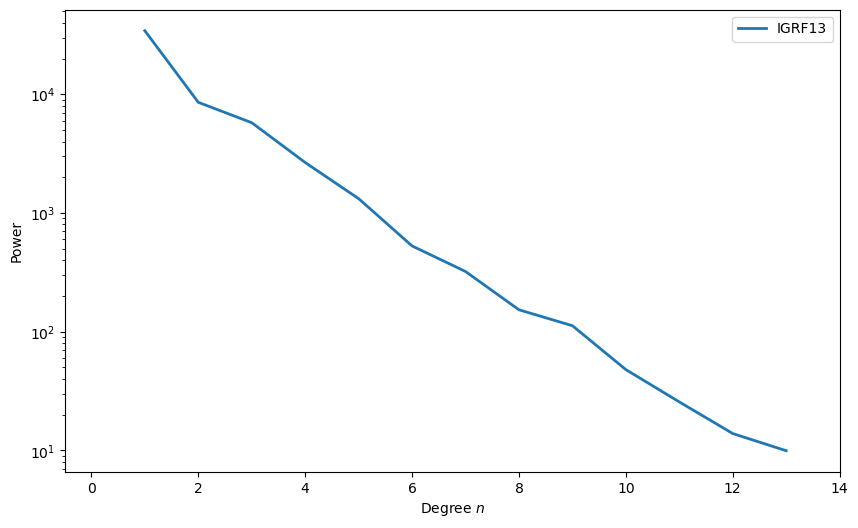

In [5]:
degree = np.zeros(nmax+1)
power = np.zeros(nmax+1)
for n in range(nmax+1):
    degree[n] = n
    power[n] = 1e-7
    for m in range(n+1):
        degree[n] = n
        power[n]  = power[n] + np.sqrt(Cnm[n,m,0]**2 + Cnm[n,m,1]**2)

print(degree[0],power[0])
plt.figure(figsize=(10,6))
plt.xlabel('Degree $n$')
plt.ylabel('Power')
plt.xlim([-0.5,14])
plt.semilogy(degree,power,linewidth=2,label='IGRF13')
plt.legend()

----
## Reconstruct magnetic potential and magnetic field

Define coordinates as sampling points:
- $\theta \in [0,180]$ co-latitude
- $\phi \in [0,360]$ longitude

In [6]:
# define coordinates (in radiants)
d2r   = np.pi/180.
nlong = 101; ncolat = 51
#nlong = 201; ncolat = 101
colat,dcolat = np.linspace(0, np.pi, ncolat,retstep=True)
long,dlong  = np.linspace(0, 2*np.pi, nlong,retstep=True)
print(colat.shape)
print(dcolat,dlong)
#dcolat,dlong = dcolat/d2r, dlong/d2r
print(dcolat,dlong)
colat, long = np.meshgrid(colat, long)
print(colat.shape)

(51,)
0.06283185307179587 0.06283185307179587
0.06283185307179587 0.06283185307179587
(101, 51)


Text(0.5, 1.0, 'Robinson Projection')

/opt/miniconda3/envs/python_R/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


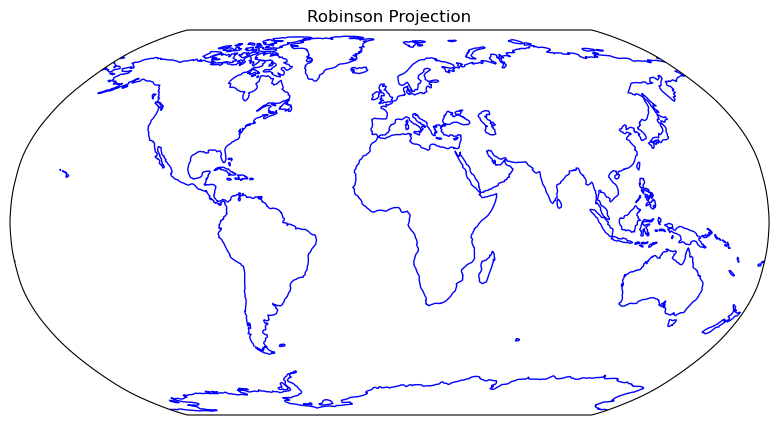

In [7]:
fig = plt.figure(figsize=(10,5))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(color='blue')
plt.title("Robinson Projection")

Re-assemble **magnetic potential** $V$ [nT m] by summing up over spherical harmonics:
$$
V(r,\theta,\phi) = a \sum\limits_{n=1}^{n_{max}} \sum\limits_{m=0}^{n}
\left( \frac{a}{r} \right)^{n+1}
 C_{nm} Y_{nm}(\theta,\phi)
$$

In [8]:
import warnings
warnings.filterwarnings('ignore')

(101, 51)


Text(0, 0.5, 'Mag. potential [Vs/m]')

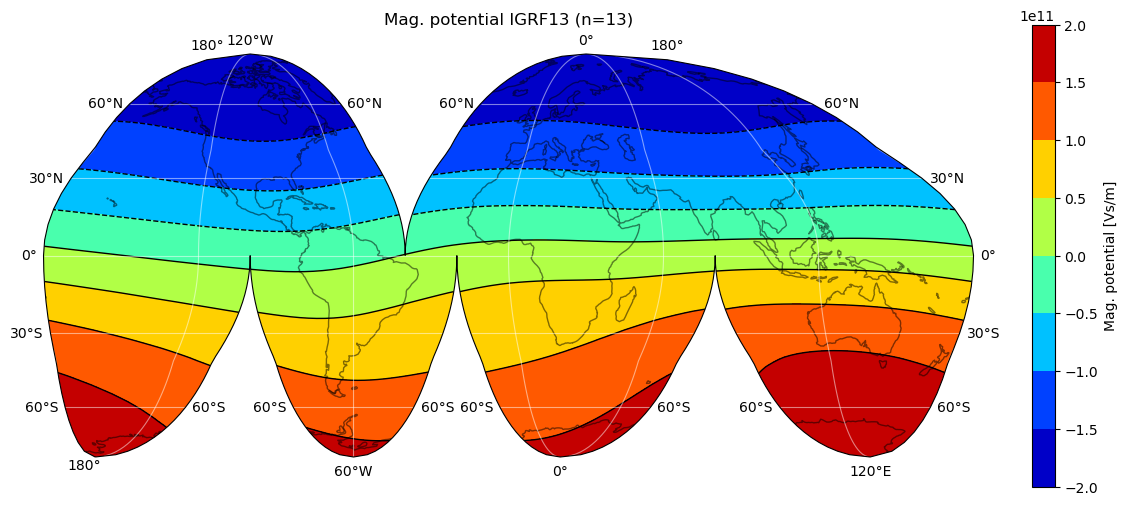

In [9]:
n = 13
m = n
V = np.zeros(nlong*ncolat).reshape(nlong,ncolat)
print(V.shape)

for n in range(1,n+1):
    for m in range(n+1):
        Ynm = sph_harm(m, n, long, colat) * np.sqrt(4*np.pi) / np.sqrt(2*n+1) # from 4pi norm to Schmidt norm
        V = V + (a/r)**(n+1) * (Cnm[n,m,0]*Ynm.real + Cnm[n,m,1]*Ynm.imag)
V = a*V

# define figure, map projection, coastlines, and gridlines
fig = plt.figure(figsize=(15,10))
#axs = plt.axes(projection=ccrs.Robinson())
axs = plt.axes(projection=ccrs.InterruptedGoodeHomolosine())
axs.coastlines(color='black',alpha=0.5)
axs.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,color='white',alpha=0.5)
# plot geoid map on top, add color bar
axs.set_title('Mag. potential '+name1+' (n='+str(n)+')')
cm=axs.contourf(long/d2r-180,90-colat/d2r,V,transform=ccrs.PlateCarree(),cmap='jet')
axs.contour(long/d2r-180,90-colat/d2r,V,transform=ccrs.PlateCarree(),linewidths=1,colors='black')
cbar=fig.colorbar(cm,shrink=0.6)
cbar.ax.set_ylabel('Mag. potential [Vs/m]')

Calculate magnetic flux components from the gradient of the magnetic potential:
$$
\vec{B} = - \nabla V
$$
$$
\vec{B} =
\left(
\begin{array}{c}
-\frac{\partial V}{\partial r} \\
-\frac{1}{r} \frac{\partial V}{\partial \Theta} \\
-\frac{1}{r \sin\Theta} \frac{\partial V}{\partial \Phi} \\
\end{array}
\right)
$$

First $B_r$ [nT] by explicitely calculating the radial derivative:
$$
B_r(r,\theta,\phi) = -\sum\limits_{n=1}^{n_{max}} \sum\limits_{m=0}^{n}
- (n+1) \left( \frac{a}{r} \right)^{n+2}
 C_{nm} Y_{nm}(\theta,\phi)
$$

(101, 51)


Text(0, 0.5, 'B$_r$ [nT]')

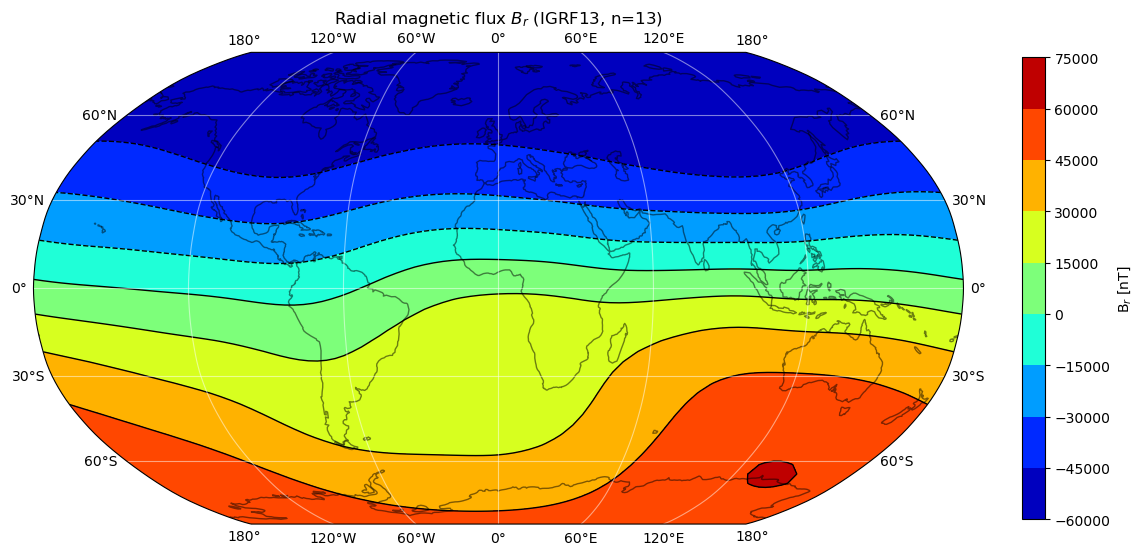

In [10]:
n = 13
m = n
Br = np.zeros(nlong*ncolat).reshape(nlong,ncolat)
print(Br.shape)

for n in range(1,n+1):
    for m in range(n+1):
        Ynm = sph_harm(m, n, long, colat) * np.sqrt(4*np.pi) / np.sqrt(2*n+1) # from 4pi norm to Schmidt norm
        Br = Br - (n+1) * (a/r)**(n+2) *(Cnm[n,m,0]*Ynm.real + Cnm[n,m,1]*Ynm.imag)
Br = -Br
        
fig = plt.figure(figsize=(15,10))
axs = plt.axes(projection=ccrs.Robinson())
axs.coastlines(color='black',alpha=0.5)
axs.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,color='white',alpha=0.5)
# plot geoid map on top, add color bar
axs.set_title('Radial magnetic flux $B_r$ ('+name1+', n='+str(n)+')')
cm=axs.contourf(long/d2r-180,90-colat/d2r,Br,transform=ccrs.PlateCarree(),cmap='jet')
axs.contour(long/d2r-180,90-colat/d2r,Br,transform=ccrs.PlateCarree(),linewidths=1.0,colors='black')
cbar=fig.colorbar(cm,shrink=0.6)
cbar.ax.set_ylabel('B$_r$ [nT]')

Then $B_{\\theta}$ [nT] and $B_{\\phi}$ [nT], using the 2D gradient routine
`np.gradient`. Note that the differential distance is used in radians,
and that we need to scale with the radius $r$, but **not** use the $\sin(\theta)$ term.

Text(0, 0.5, '$B_{\\phi}$ [nT]')

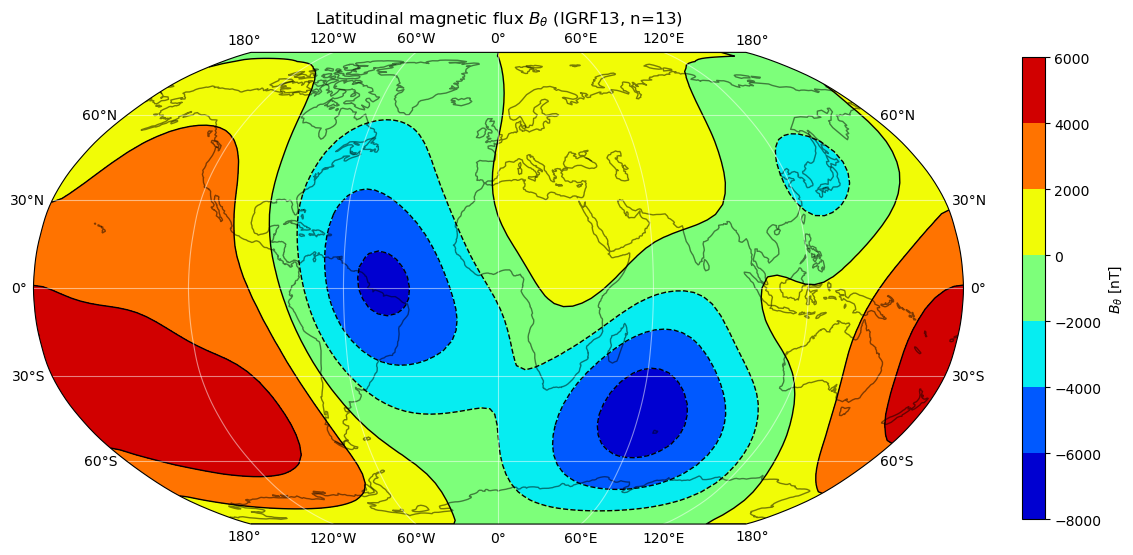

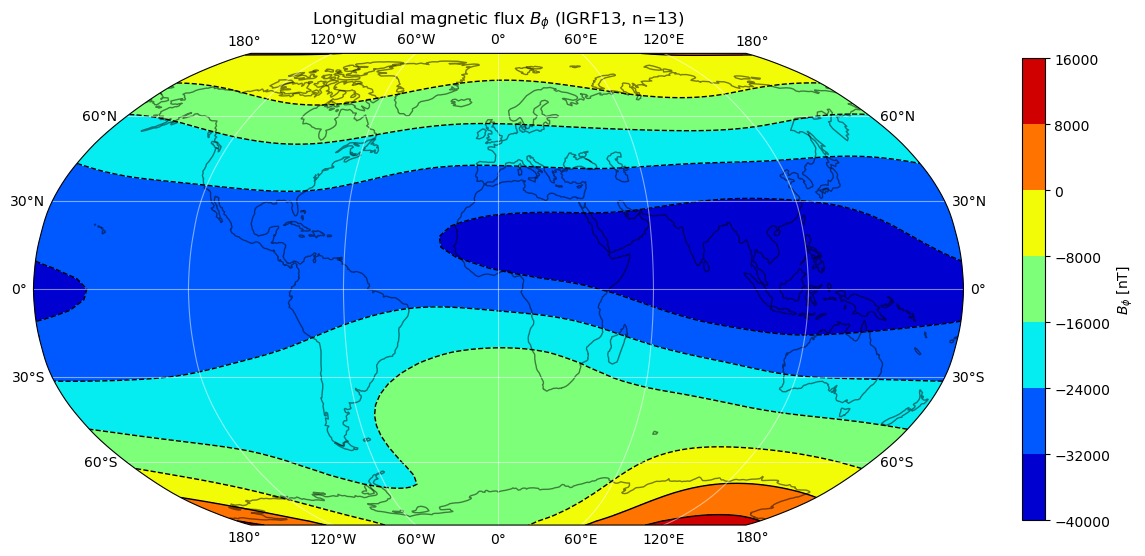

In [24]:
Btheta,Bphi = np.gradient(V,dcolat,dlong)
Btheta = -1/r*Btheta
Bphi   = -1/r*Bphi

fig = plt.figure(figsize=(15,10))
axs = plt.axes(projection=ccrs.Robinson())
axs.coastlines(color='black',alpha=0.5)
axs.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,color='white',alpha=0.5)
# plot geoid map on top, add color bar
axs.set_title('Latitudinal magnetic flux $B_{\\theta}$ ('+name1+', n='+str(n)+')')
cm=axs.contourf(long/d2r-180,90-colat/d2r,Btheta,transform=ccrs.PlateCarree(),cmap='jet')
axs.contour(long/d2r-180,90-colat/d2r,Btheta,transform=ccrs.PlateCarree(),linewidths=1.0,colors='black')
cbar=fig.colorbar(cm,shrink=0.6)
cbar.ax.set_ylabel('$B_{\\theta}$ [nT]')

fig = plt.figure(figsize=(15,10))
axs = plt.axes(projection=ccrs.Robinson())
axs.coastlines(color='black',alpha=0.5)
axs.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,color='white',alpha=0.5)
# plot geoid map on top, add color bar
axs.set_title('Longitudial magnetic flux $B_{\\phi}$ ('+name1+', n='+str(n)+')')
cm=axs.contourf(long/d2r-180,90-colat/d2r,Bphi,transform=ccrs.PlateCarree(),cmap='jet')
axs.contour(long/d2r-180,90-colat/d2r,Bphi,transform=ccrs.PlateCarree(),linewidths=1.0,colors='black')
cbar=fig.colorbar(cm,shrink=0.6)
cbar.ax.set_ylabel('$B_{\\phi}$ [nT]')

Text(0, 0.5, 'Total field [nT]')

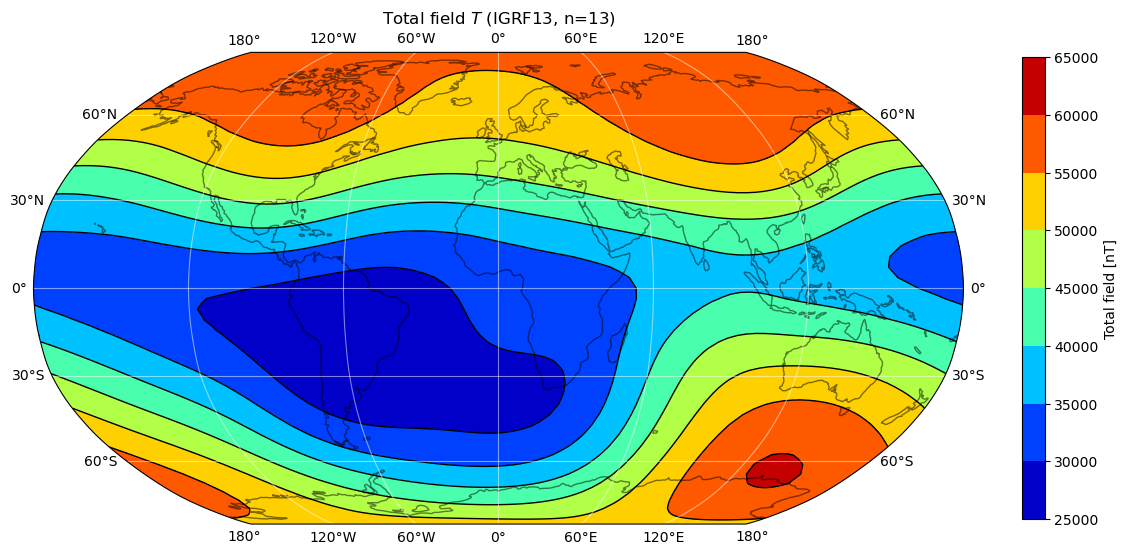

In [25]:
T = np.sqrt(Br**2 + Btheta**2 + Bphi**2)

fig = plt.figure(figsize=(15,10))
axs = plt.axes(projection=ccrs.Robinson())
axs.coastlines(color='black',alpha=0.5)
axs.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,color='white',alpha=0.5)
# plot geoid map on top, add color bar
axs.set_title('Total field $T$ ('+name1+', n='+str(n)+')')
cm=axs.contourf(long/d2r-180,90-colat/d2r,T,transform=ccrs.PlateCarree(),cmap='jet')
axs.contour(long/d2r-180,90-colat/d2r,T,transform=ccrs.PlateCarree(),linewidths=1.0,colors='black')
cbar=fig.colorbar(cm,shrink=0.6)
cbar.ax.set_ylabel('Total field [nT]')

... done